In [1]:
#default params
options(max.print = 100)
#input file paths
rna_enhancers_counts_path = "Analysis/10X_PBMC/04_count/pbmc_granulocyte_sorted_10k_counts_per_cell.txt"
enhancers_metadata_path = "Analysis/enhancers/tcea_super_enhancers/tcea_super_enhancers_enhancers_metadata.txt"
gex_lib_size_path = "Analysis/10X_PBMC/gex_clustering/PBMC_RNA_lib_size.RDS"
# Parameters for filtering enhancers/cells and thresholds
# min_cells: keep only enhancers expressed in at least X cells
# min_enhancers: keep only cells that express at least X enhancers
# rna_threshold: minimum RNA expression to count as expressed
# atac_threshold: minimum ATAC signal to count as expressed

# Defaults (you can change these when running the notebook)
min_cells <- 10        # X: enhancer must be seen in at least this many cells
min_enhancers <- 10   # X: cell must express at least this many enhancers
lib_size_normalize = "erna"  # options: "erna" or "gex" or "none"
#output file paths
filtered_erna_path = "Analysis/10X_PBMC/05_erna_preprocess/filtered_erna_pbmc_granulocyte_sorted_10k.rds"

In [2]:
# Parameters
min_cells = 10
min_enhancer_counts = 10
rna_enhancers_counts_path = "Analysis/10X_PBMC/04_count/pbmc_granulocyte_sorted_10k_counts_per_cell.txt"


# eRNA count matrix -raw analysis

In [3]:
library(magrittr)
library(dplyr)
library(stringi)
library(Matrix)
library(ggplot2)
library(patchwork)
library(ggpubr)


Attaching package: ‘dplyr’




The following objects are masked from ‘package:stats’:

    filter, lag




The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [4]:
setwd(here::here()) # set working directory to project root
getwd()

[1] "/sci/labs/yotamd/lab_share/avishai.wizel/Projects/eRNA"

Load data:

In [5]:
library(data.table)

rna_enhancers <- data.table::fread(rna_enhancers_counts_path, header = TRUE, sep = "\t", data.table = FALSE)



Attaching package: ‘data.table’




The following objects are masked from ‘package:dplyr’:

    between, first, last




In [6]:
# gene column to rownames
rownames(rna_enhancers) <- rna_enhancers$gene
rna_enhancers$gene <- NULL

In [7]:
rna_enhancers[1:10, 1:10]

,AAACAGCCAAGGAATC,AAACAGCCAATCCCTT,AAACAGCCAATGCGCT,AAACAGCCACACTAAT,AAACAGCCACCAACCG,AAACAGCCAGGATAAC,AAACAGCCAGTAGGTG,AAACAGCCAGTTTACG,AAACAGCCATCCAGGT,AAACATGCAAGGTCCT
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr10:101688237,0,0,0,0,0,0,0,0,0,0
chr10:101753121,0,0,0,0,0,0,0,0,0,0
chr10:101753771,0,0,0,0,0,0,0,0,0,0
chr10:101754231,0,0,0,0,0,0,0,0,0,0
chr10:101754591,0,0,0,0,0,0,0,0,0,0
chr10:101768951,0,0,0,0,0,0,0,0,0,0
chr10:101769151,0,0,0,0,0,0,0,0,0,0
chr10:102791461,0,0,0,0,0,0,0,0,0,0
chr10:103702315,0,0,0,0,0,0,0,0,0,0


In [8]:
dim(rna_enhancers)

[1] 22238 11892

In [9]:
rna_enhancers = Matrix(as.matrix(rna_enhancers),sparse = TRUE)

In [10]:
# unexpressed cells count
unexpr_cells = colSums(rna_enhancers==0)
print(paste0("unexpressed cells: ", sum(unexpr_cells==nrow(rna_enhancers))," out of ", ncol(rna_enhancers)))
# unexpressed rows count
unexpr_rows = rowSums(rna_enhancers==0)
print(paste0("unexpressed eRNA: ", sum(unexpr_rows==ncol(rna_enhancers))," out of ", nrow(rna_enhancers)))



[1] "unexpressed cells: 0 out of 11892"


[1] "unexpressed eRNA: 0 out of 22238"


In [11]:
# precent of zeros in the matrix
print(paste0(" precent of zeros: ",sum(rna_enhancers == 0) / (nrow(rna_enhancers) * ncol(rna_enhancers))))



[1] " precent of zeros: 0.996862255548308"


In [12]:
# show first 100 sums of cells
colSums(rna_enhancers) %>% head(10)

AAACAGCCAAGGAATC AAACAGCCAATCCCTT AAACAGCCAATGCGCT AAACAGCCACACTAAT 
             139               77              102               19 
AAACAGCCACCAACCG AAACAGCCAGGATAAC AAACAGCCAGTAGGTG AAACAGCCAGTTTACG 
              82               49              111               48 
AAACAGCCATCCAGGT AAACATGCAAGGTCCT 
             142               55

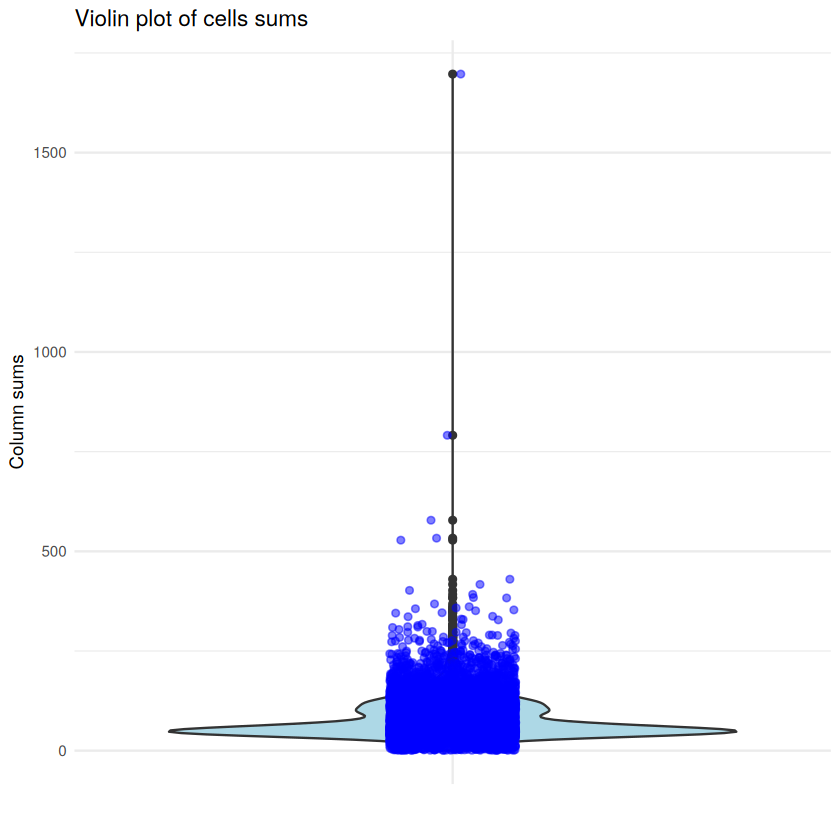

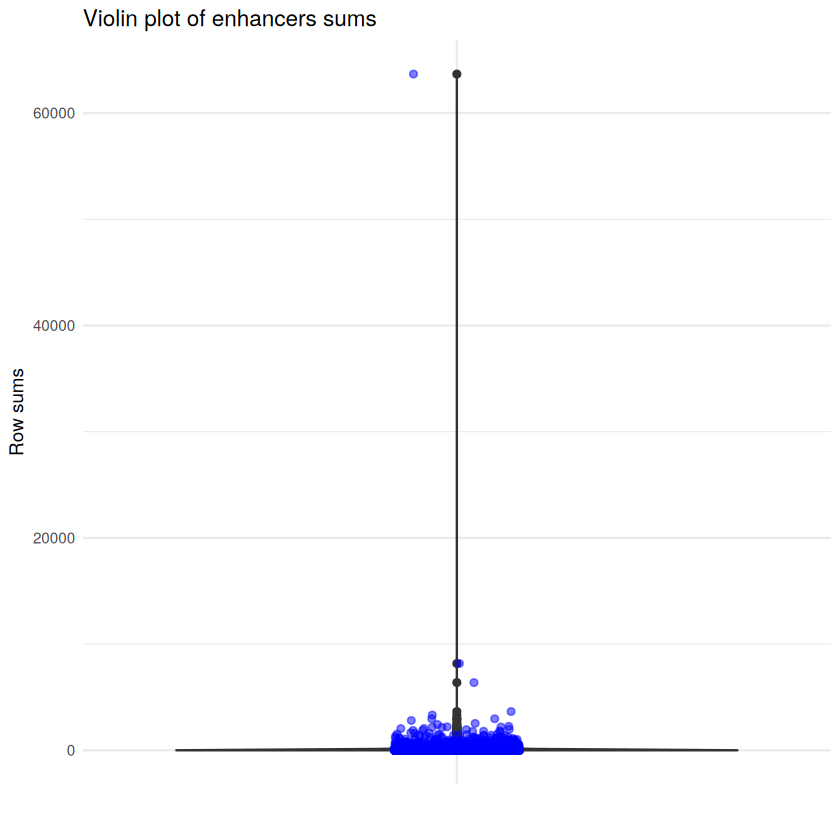

In [13]:
# violin plot of column sums with jittered points
data_cols = data.frame(sum = colSums(rna_enhancers))
p = ggplot(data_cols, aes(x = "", y = sum)) +
  geom_violin(fill = "lightblue") +
  geom_boxplot(width = 0.1, fill = "lightgreen") +
  geom_jitter(width = 0.1, alpha = 0.5, color = "blue",height = 0) +
  labs(title = "Violin plot of cells sums", x = "", y = "Column sums") +
  theme_minimal()

print(p)
# violin plot of row sums
data_rows = data.frame(sum = rowSums(rna_enhancers))
p = ggplot(data_rows, aes(x = "", y = sum)) +
  geom_violin(fill = "lightblue") +
  geom_boxplot(width = 0.1, fill = "lightgreen") +
  geom_jitter(width = 0.1, alpha = 0.5, color = "blue",height = 0) +
  labs(title = "Violin plot of enhancers sums", x = "", y = "Row sums") +
  theme_minimal()
print(p)


# QC

In [14]:
# keep only enhancers that expressed in at least min_cells cells
rows_to_keep = which(rowSums(rna_enhancers >= 1) >= min_cells)
print(length(rows_to_keep))
print( "enhancers out of " )
print(nrow(rna_enhancers))

# keep only cells that expressed in at least min_enhancers enhancers
cols_to_keep = which(colSums(rna_enhancers >= 1) >= min_enhancers)
print(length(cols_to_keep))
print( "cells out of " )
print(ncol(rna_enhancers))


[1] 10570


[1] "enhancers out of "


[1] 22238


[1] 11719


[1] "cells out of "


[1] 11892


In [15]:
rna_enhancers = rna_enhancers[rows_to_keep, cols_to_keep]

# Metadata

In [16]:
enhancers_metadata <- data.table::fread(enhancers_metadata_path, header = T, sep = "\t", data.table = FALSE)

# Normalization

In [17]:
# normalize by length
rna_enhancers_len_normalized <- rna_enhancers

# enhancers_length_vector <- enhancers_metadata$length[match(rownames(rna_enhancers), enhancers_metadata$id)]
# rna_enhancers_len_normalized@x <- rna_enhancers_len_normalized@x / enhancers_length_vector[rna_enhancers_len_normalized@i + 1]

# #restore cell names after filtering
# colnames(rna_enhancers_len_normalized) <- colnames(rna_enhancers)

In [18]:
print(summary(rna_enhancers@x))
print(summary(rna_enhancers_len_normalized@x))
print(head(rna_enhancers@x))
print(head(rna_enhancers_len_normalized@x))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.135   1.000 105.000 


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.135   1.000 105.000 


[1] 1 1 1 1 1 1


[1] 1 1 1 1 1 1


In [19]:
# 1. Ensure cell names in gex_lib_size match the columns in your enhancer matrix
# We subset the matrix to include only cells present in your filtered GEX lib size
if (lib_size_normalize == "gex") {
    gex_lib_size = readRDS(gex_lib_size_path)
    print("Normalizing by GEX library size")
    #remove "-1" from cell names in gex_lib_size
    names(gex_lib_size) <- stri_replace_last_fixed(names(gex_lib_size), "-1", "")
    common_cells <- intersect(colnames(rna_enhancers_len_normalized), names(gex_lib_size))
    rna_enhancers_len_normalized <- rna_enhancers_len_normalized[, common_cells]
    current_lib_size <- gex_lib_size[common_cells]
} else if (lib_size_normalize == "erna") {
  print("Normalizing by eRNA library size")
  current_lib_size = colSums(rna_enhancers_len_normalized)
} else {
  print("No library size normalization applied")
    current_lib_size = rep(1, ncol(rna_enhancers_len_normalized) ) # no library size normalization
}


#Normalize to TPM
# 2. Normalize by GEX Library Depth
# We use the diagonal matrix trick to avoid dense coercion
d_inv_gex <- Diagonal(x = 1 / current_lib_size)
rna_enhancers_normalized <- rna_enhancers_len_normalized %*% d_inv_gex
# 3. Apply Scaling Factor (e.g., 10,000 or 1,000,000 for TPM)
# We multiply by 1e4 (CP10K) to get manageable numbers
if (lib_size_normalize == "gex"){ 
  rna_enhancers_normalized <- rna_enhancers_normalized * 1e6 
} else if (lib_size_normalize == "erna"){ 
     rna_enhancers_normalized <- rna_enhancers_normalized * 1000

}

# 4. Final Log Transformation (Log1p)
# This is crucial for Pearson correlation to stabilize variance
#rna_enhancers_normalized@x <- log1p(rna_enhancers_normalized@x)
# 5. Restore names (optional but recommended)
rownames(rna_enhancers_normalized) <- rownames(rna_enhancers_len_normalized)
colnames(rna_enhancers_normalized) <- colnames(rna_enhancers_len_normalized)



[1] "Normalizing by eRNA library size"


In [20]:
summary(rna_enhancers_len_normalized@x)
summary(rna_enhancers_normalized@x)
head(rna_enhancers_normalized)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.135   1.000 105.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.618   7.936  11.236  14.907  18.868 456.790 

  [[ suppressing 34 column names ‘AAACAGCCAAGGAATC’, ‘AAACAGCCAATCCCTT’, ‘AAACAGCCAATGCGCT’ ... ]]



  [[ suppressing 34 column names ‘AAACAGCCAAGGAATC’, ‘AAACAGCCAATCCCTT’, ‘AAACAGCCAATGCGCT’ ... ]]



  [[ suppressing 34 column names ‘AAACAGCCAAGGAATC’, ‘AAACAGCCAATCCCTT’, ‘AAACAGCCAATGCGCT’ ... ]]



6 x 11719 sparse Matrix of class "dgCMatrix"
                                                                                          
chr10:101688237 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......

 ..............................
 ........suppressing 11685 columns and 4 rows in show(); maybe adjust 'options(max.print= *, width = *)'
 ..............................
                                                                                          
chr10:103702315 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . ......

Warning message:
“Computation failed in `stat_bin2d()`.
Caused by error in `bin2d_breaks()`:
! `origin` must be a number, not `NaN`.”


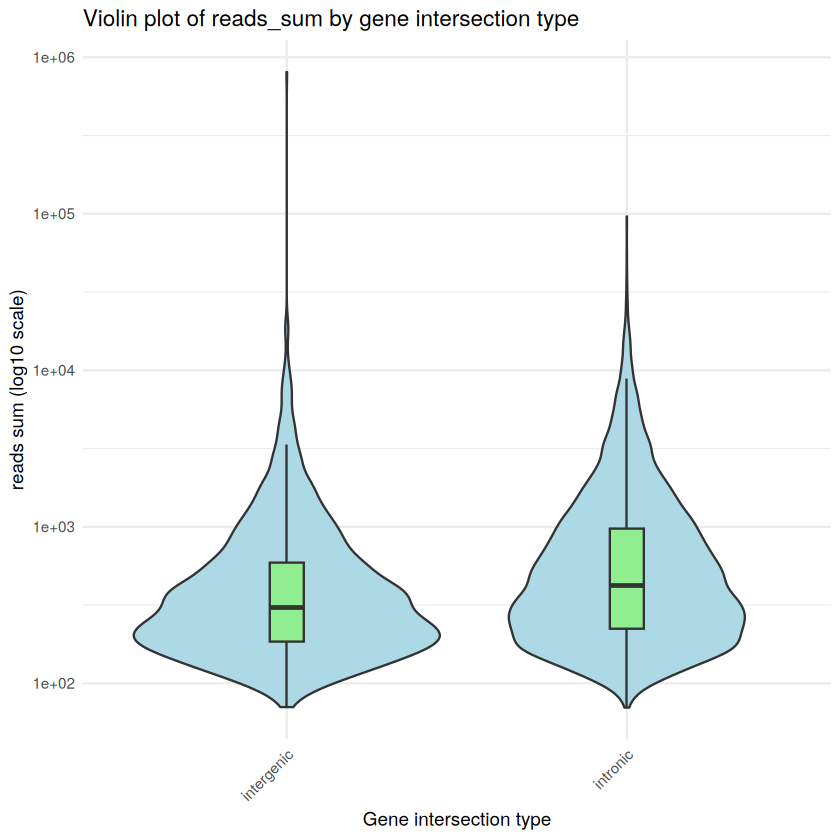

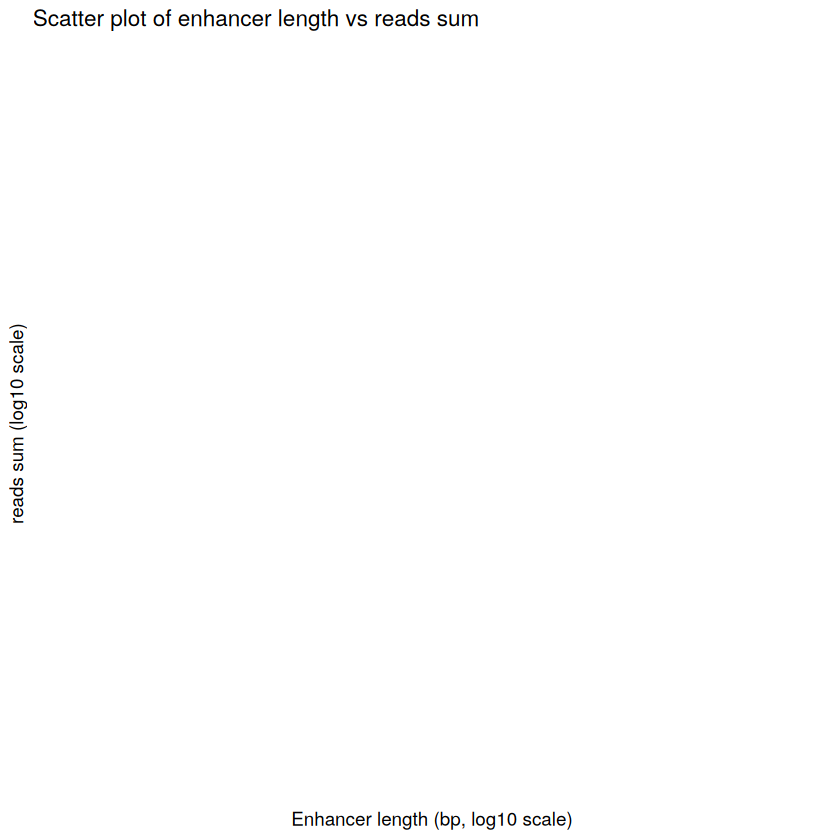

In [21]:
library(scales)
counts_per_enhancer = data.frame(row.names = rownames(rna_enhancers_normalized), reads_sum = rowSums(rna_enhancers_normalized))
counts_per_enhancer = merge(counts_per_enhancer, enhancers_metadata, by.x = "row.names", by.y = "id")
colnames(counts_per_enhancer)[1] <- "id"
#violin plot of average expression by gene intersection type
p = ggplot(counts_per_enhancer, aes(x = gene_intersection, y = reads_sum)) +
  geom_violin(fill = "lightblue") +
  geom_boxplot(width = 0.1, fill = "lightgreen", outlier.shape = NA) +
  scale_y_log10() +  # Transform y-axis to log10 scale
  labs(title = "Violin plot of reads_sum by gene intersection type", x = "Gene intersection type", y = "reads sum (log10 scale)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
print(p)

p = ggplot(counts_per_enhancer, aes(x = length, y = reads_sum)) +
  geom_bin2d(bins = 50) +
  scale_x_log10() +  # Transform x-axis to log10 scale
  scale_y_continuous(breaks = breaks_log(n = 10),trans = "log10",labels = label_number( big.mark = ",")) +  # Add y-axis ticks at regular intervals
  labs(title = "Scatter plot of enhancer length vs reads sum", x = "Enhancer length (bp, log10 scale)", y = "reads sum (log10 scale)") +
  theme_minimal()+
  geom_smooth(method = "lm", formula = y ~ x) +
  stat_cor()
print(p)


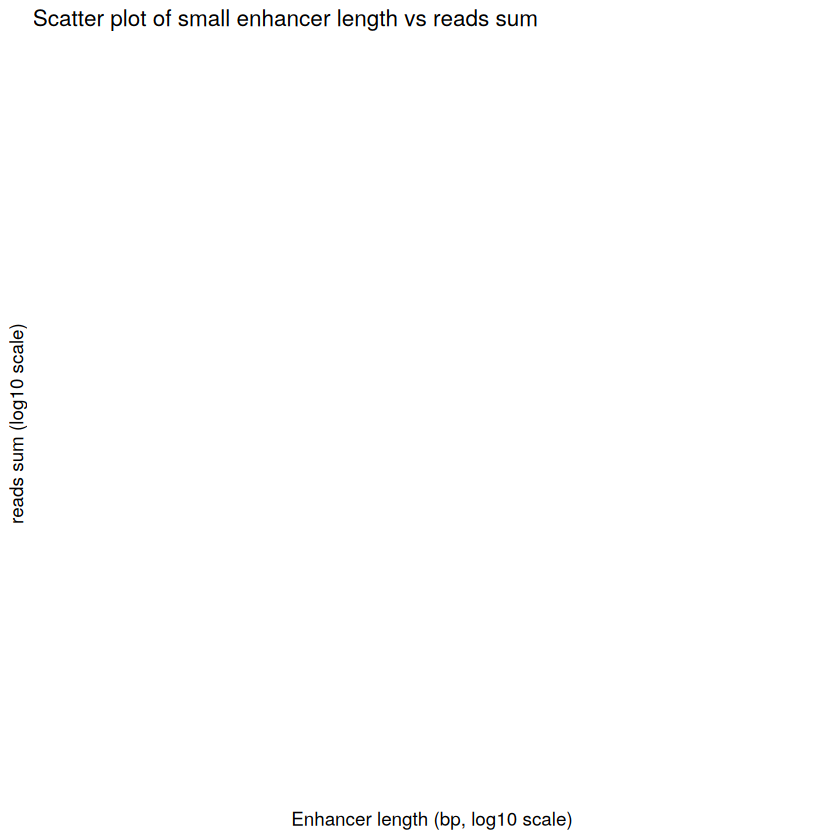

In [22]:
# plot only enhancers with length < 300 bp
p = ggplot(filter(counts_per_enhancer,length<300), aes(x = length, y = reads_sum)) +
  geom_bin2d(bins = 50) +
  scale_x_log10() +  # Transform x-axis to log10 scale
  scale_y_continuous(breaks = breaks_log(n = 10),trans = "log10",labels = label_number( big.mark = ",")) +  # Add y-axis ticks at regular intervals
  labs(title = "Scatter plot of small enhancer length vs reads sum", x = "Enhancer length (bp, log10 scale)", y = "reads sum (log10 scale)") +
  theme_minimal()+
  geom_smooth(method = "lm", formula = y ~ x) +
  stat_cor()
print(p)

In [23]:
saveRDS(rna_enhancers_normalized, file = filtered_erna_path)